### EE 421/521 Image Processing

## Project 4 - Frequency Domain Processing


In this project, you will implement the following filters in the **Fourier** domain:

1. Ideal low-pass filter
2. Ideal high-pass filter
3. Ideal horizontal low-pass filter
4. Ideal horizontal high-pass filter

**This project will be graded for both EE 421 (HW3) and EE 521 (HW3) students.**

*Copyright (c) 2020-2022 by Arif Tanju Erdem*

In [225]:
# STEP 0 Import the necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib.pyplot as plt

# array operations
import numpy as np

# signal processing operations
from scipy import signal
from scipy.linalg import circulant

# DFT calculations
from scipy import fftpack as ft

# mathematical calculations
import math
import cmath


# Mount Google Drive folder to Colab
from google.colab import drive
drive.mount('/content/drive',force_remount = True)


Mounted at /content/drive


In [226]:
# my function to set P to 0 if M infinitesmall
# (e.g., for setting phase to 0 when magnitude is infinitesmall)

def my_epsilon2zero(P, M):

    epsilon = 1.0e-6

    shapeP = P.shape
    shapeM = M.shape
    assert shapeP == shapeM

    P = P.reshape(-1)
    M = M.reshape(-1)

    for i in range(P.size):
        if M[i] < epsilon:
            P[i] = 0.0

    return P.reshape(shapeP)

# end of function

In [227]:
# my function to obtain a display-friendly version of 2-D DFT of an image
# (used for displaying DFT magnitude, DFT real part, and DFT imaginary part)

def my_log_display(X):

    shapeX = X.shape
    X = X.reshape(-1)

    for i in range(X.size):
        if X[i] < 0:
            # this is needed for real and imaginary parts
            X[i] = - np.log(1-X[i])
        else:
            # magnitude is always non-negative
            X[i] = np.log(1+X[i])

    return X.reshape(shapeX)

# end of function

In [228]:
# my function to multiply an image with (-1)^(i+j)
# so that the origin of its DFT is displayed at the center

def my_img_shift(img):

    height, width = img.shape
    assert height%2 == 0 and width%2 == 0

    img_shift = img.copy() + 0.0

    for i in range(height):
        for j in range(width):
            if (i+j)%2 == 1:
                img_shift[i,j] *= -1.0

    return img_shift

# end of function

In [229]:
# my function to round image data to nearest integer, then
# truncate to range [0, 255], and then set data type to uint8

def my_imgTruncate(img):

    img = np.round(img, 0)
    img = np.minimum(img, 255)
    img = np.maximum(img, 0)
    img = img.astype('uint8')

    return img

# end of function

In [230]:
# my function to construct a low/high-pass rectangular uniform mask

def my_mask_Rectangle(img_shape, mask_shape, isLowPass = True):

    assert len(img_shape) == 2 and len(mask_shape) == 2
    assert mask_shape < img_shape

    # height & width of image
    hi, wi = img_shape

    # height & width of mask
    hm, wm = mask_shape

    if isLowPass:
        # zero except at the center
        img_mask = np.zeros(img_shape)
        val = 1
    else:
        # one except at the center
        img_mask = np.ones(img_shape)
        val = 0

    # set the center value (1 for low pass, 0 for high pass)
    img_mask[(hi-hm)//2:(hi+hm)//2, (wi-wm)//2:(wi+wm)//2] = val

    return img_mask

# end of function

In [231]:
# my function to convert to lumincance, round to nearest integer,
# truncate to range [0, 255], and then set data

def my_imgLuminance(imgRGB):

    # make sure it is a color image
    dim_img = imgRGB.shape[2]
    assert dim_img >= 3

    # get the luminance data
    if dim_img == 3:
        imgLum = color.rgb2gray(imgRGB)
    else:
        # ignore the alpha channel
        imgLum = color.rgb2gray(imgRGB[:,:,0:3])

    imgLum = np.round(imgLum * 255, 0)
    imgLum = np.minimum(imgLum, 255)
    imgLum = np.maximum(imgLum, 0)
    imgLum = imgLum.astype('uint8')

    return imgLum

# end of function

Image width is 256 and image height is 256.
Image data type is uint8.



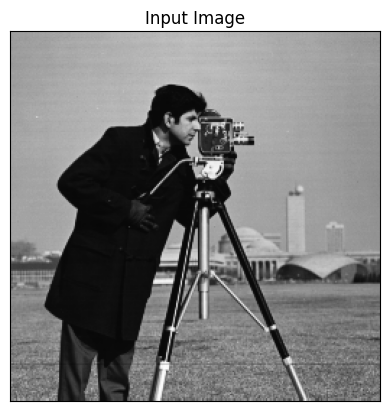

In [232]:
# STEP 1 Pick an image for filtering

# set image folder
image_folder = r'/content/drive/MyDrive/Colab Notebooks/421_Images'

# read input image
image_file = r'/cameraman.tiff'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

if imgRGB.ndim >= 3:
    # color image
    # calculate the luminance image
    x_img = my_imgLuminance(imgRGB)
else:
    # monochrome image
    x_img = imgRGB

height = x_img.shape[0]
width = x_img.shape[1]
datatype = x_img.dtype

print("Image width is {} and image height is {}.".format(width, height))
print("Image data type is {}.\n".format(datatype))

# display luminance image
plt.imshow(x_img, cmap='gray', vmin=0, vmax=255)
plt.title('Input Image')
plt.xticks([]), plt.yticks([])
plt.show()

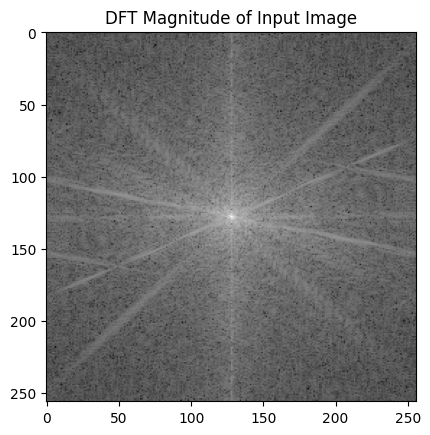

In [233]:
# STEP 2 Take the DFT of the image

# multiply the image with (-1)^(i+j) before DFT so that DFT origin is displayed at the center
# note that for this to work, both image width and height must be even
x_img_shift = my_img_shift(x_img)

# calculate the 2-D DFT via SciPy's 2-D DFT function
X_img_shift = ft.fft2(x_img_shift)

# get DFT size
height, width = X_img_shift.shape

# get a display friendly version for DFT magnitude
X_img_mag_pr = my_log_display(np.abs(X_img_shift))

# get min and max values for scaling during display
mag_max = X_img_mag_pr.max()
mag_min = X_img_mag_pr.min()

# display the DFT magnitude of the image
plt.imshow(X_img_mag_pr, cmap='gray')
plt.title('DFT Magnitude of Input Image')
plt.show()

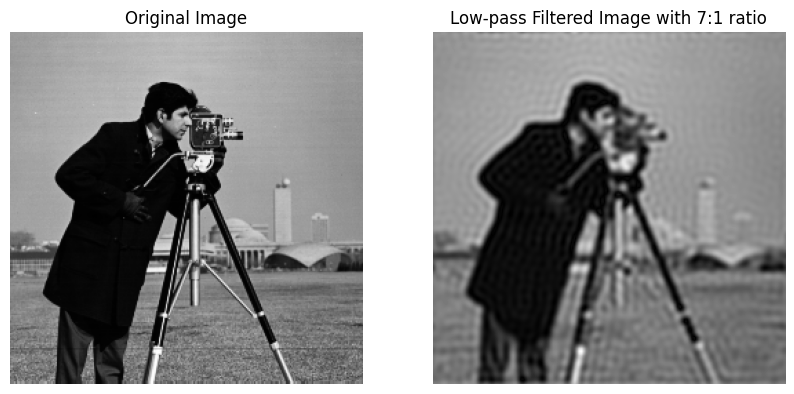

In [234]:
# STEP 3 Apply an ideal low-pass filter in the Fourier domain

#---------------------------------------------------------------
# 7:1 ideal low-pass filter implementation in the Fourier domain
#---------------------------------------------------------------

def low_pass_filter(img, cutoff_ratio):
    # Fourier Transform
    f_img = ft.fft2(img)
    f_shift = ft.fftshift(f_img)

    # Mask for low-pass filter
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # Cutoff frequency
    cutoff_frequency = min(rows, cols) / cutoff_ratio

    # Mask
    mask = np.zeros((rows, cols), dtype=np.float64)
    mask[np.sqrt((np.arange(rows) - crow)**2+(np.arange(cols)[:,np.newaxis]-ccol)**2) <=cutoff_frequency] = 1
    f_shift_filtered = f_shift * mask

    # Inverse Fourier Transform
    img_filtered = ft.ifftshift(f_shift_filtered)
    img_filtered = ft.ifft2(img_filtered)
    img_filtered = np.abs(img_filtered)

    return img_filtered

# Read the image
img = io.imread(image_path, as_gray=True)

# Low-pass filter (cutoff ratio = 7:1)
cutoff_ratio = 7
filtered_img = low_pass_filter(img, cutoff_ratio)

#---------------------------------------------------------------
# Display original and filtered image
#---------------------------------------------------------------
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img,cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_img,cmap='gray')
plt.title('Low-pass Filtered Image with 7:1 ratio')
plt.axis('off')
plt.show()





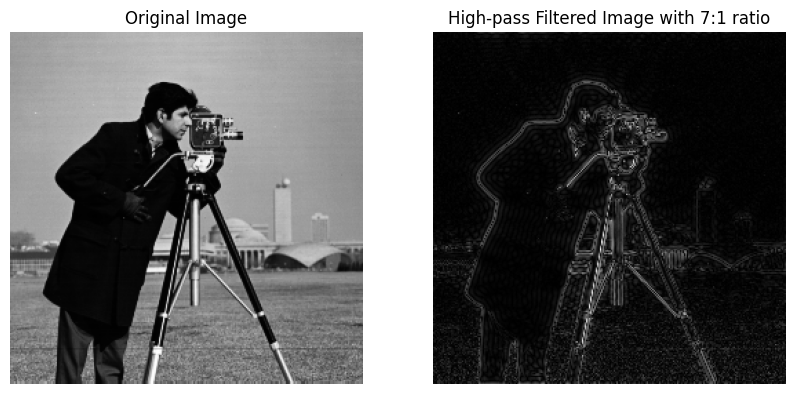

In [235]:
# STEP 4 Apply an ideal high-pass filter in the Fourier domain

#---------------------------------------------------------------
# 7:1 ideal high-pass filter implementation in the Fourier domain
#---------------------------------------------------------------

def high_pass_filter(img, cutoff_ratio):
    # Fourier Transform
    f_img = ft.fft2(img)
    f_shift = ft.fftshift(f_img)

    # Mask for the high-pass filter
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # Cutoff frequency
    cutoff_frequency = min(rows,  cols) / cutoff_ratio

    # Mask
    mask = np.ones((rows, cols), dtype=np.float64)
    mask[np.sqrt((np.arange(rows) - crow)**2 + (np.arange(cols)[:,np.newaxis] - ccol)**2) <= cutoff_frequency] = 0
    f_shift_filtered = f_shift * mask

    # Inverse Fourier Transform
    img_filtered = ft.ifftshift(f_shift_filtered)
    img_filtered = ft.ifft2(img_filtered)
    img_filtered = np.abs(img_filtered)

    return img_filtered

# Read the image
img = io.imread(image_path, as_gray=True)

# High-pass filter (cutoff ratio = 7:1)
cutoff_ratio = 7
filtered_img = high_pass_filter(img, cutoff_ratio)

#---------------------------------------------------------------
# Display original and filtered image
#---------------------------------------------------------------

plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap='gray')
plt.title('High-pass Filtered Image with 7:1 ratio')
plt.axis('off')

plt.show()



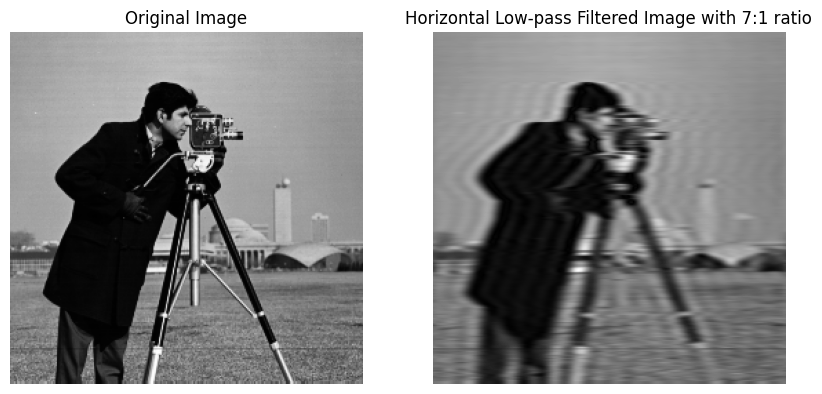

In [236]:
# STEP 5 Apply an ideal horizontal low-pass filter in the Fourier domain

#---------------------------------------------------------------
# 7:1 ideal horizontal low-pass filter implementation in the Fourier domain
#---------------------------------------------------------------

def horizontal_low_pass_filter(img, cutoff_ratio):
    # Fourier Transform
    f_img = ft.fft2(img)
    f_shift = ft.fftshift(f_img)

    # Mask for the horizontal low-pass filter
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # Cutoff frequency
    cutoff_frequency = cols/cutoff_ratio

    # Create mask
    mask = np.zeros((rows, cols), dtype=np.float64)
    mask[:, (ccol-int(cutoff_frequency/2)):(ccol+int(cutoff_frequency/2))] = 1

    # Apply the mask
    f_shift_filtered = f_shift * mask

    # Perform Inverse Fourier Transform
    img_filtered = ft.ifftshift(f_shift_filtered)
    img_filtered = ft.ifft2(img_filtered)
    img_filtered = np.abs(img_filtered)

    return img_filtered

# Read the image
img = io.imread(image_path, as_gray=True)

# Horizontal low-pass filter (cutoff ratio of 7:1)
cutoff_ratio = 7
filtered_img = horizontal_low_pass_filter(img,cutoff_ratio)

#---------------------------------------------------------------
# Display original and filtered images
#---------------------------------------------------------------
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_img, cmap='gray')
plt.title('Horizontal Low-pass Filtered Image with 7:1 ratio')
plt.axis('off')

plt.show()



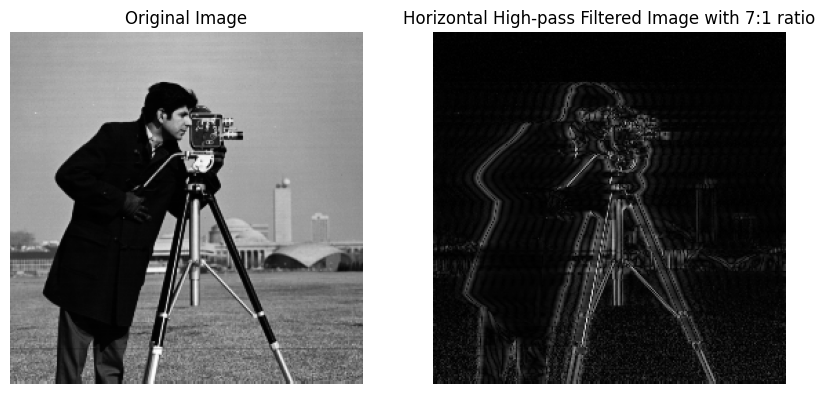

In [237]:
# STEP 6 Apply an ideal horizontal high-pass filter in the Fourier domain

#---------------------------------------------------------------
# 7:1 ideal horizontal high-pass filter implementation in the Fourier domain
#---------------------------------------------------------------

def horizontal_high_pass_filter(img, cutoff_ratio):
    # Fourier Transform
    f_img = ft.fft2(img)
    f_shift = ft.fftshift(f_img)

    # Mask for horizontal high-pass filter
    rows, cols = img.shape
    crow, ccol = rows//2, cols//2

    # Cutoff frequency
    cutoff_frequency = cols/cutoff_ratio

    # Mask
    mask = np.ones((rows, cols), dtype=np.float64)
    mask[:, (ccol - int(cutoff_frequency / 2)):(ccol + int(cutoff_frequency / 2))] = 0
    f_shift_filtered = f_shift*mask

    # Inverse Fourier Transform
    img_filtered = ft.ifftshift(f_shift_filtered)
    img_filtered = ft.ifft2(img_filtered)
    img_filtered = np.abs(img_filtered)

    return img_filtered

# Read the image
img = io.imread(image_path, as_gray=True)

# Horizontal high-pass filter (cutoff ratio = 7:1)
cutoff_ratio = 7
filtered_img = horizontal_high_pass_filter(img, cutoff_ratio)

#---------------------------------------------------------------
# Display original and filtered image
#---------------------------------------------------------------

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap='gray')
plt.title('Horizontal High-pass Filtered Image with 7:1 ratio')
plt.axis('off')

plt.show()



*STEP 7 Comments on the results*

*ADD YOUR COMMENTS HERE*

Comment on the results in Steps 3-6. Do they look as expected? Are there any ringing artefacts observed?

Using lowpass filter for the imag, deleted high valued frequency components. By using low-pass filter, we obtained the overall image. However while losing sharp edges (high frequency component).

There's only sharp edges in high pass filtered images, while we can see the ringing in lowpass filtered ones.

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [239]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/Prj04_Fourier_S025235.ipynb'

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/Prj04_Fourier_S025235.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent